# Algorytmy macierzowe — lab 1

### Krzysztof Kopel, Marcin Szulc

## Cel laboratorium
Celem laboratorium było zaimplementowanie i przetestowanie podstawowych algorytmów mnożenia macierzy, w tym metod Binéta, Strassena oraz Nature AI. Testowanie zaimplementowanych algorytmów polegać miało w szczególności na sprawdzeniu ich poprawności oraz oszacowaniu złożoności obliczeniowej, a także zależności czasu wykonania, zużycia pamięci i liczby operacji zmiennoprzecinkowych od rozmiaru macierzy wejściowych.

## Ustalenia techniczne
Do implementacji algorytmów wykorzystaliśmy język Python w wersji 3.13. Macierze zostały zaimplementowane jako Numpy ndarrays, które dzięki swojej implementacji są szybsze od tradycyjnych Pythonowych list wielowymiarowych, jak również posiadają kilka przydatnych dla nas metod, np. do sprawdzania rozmiaru macierzy. Każdy algorytm "opakowaliśmy" w klasę, w której zapisywaliśmy informację na temat liczby wykonanych operacji zmiennoprzecinkowych oraz zużycia pamięci (tzw. wrapper). Do pomiaru czasu wykonania posłużyła nam biblioteka time. Do wizualizacji wyników wykorzystaliśmy bibliotekę matplotlib.
#### Generowanie macierzy testowych
Wygenerowaliśmy macierze kwadratowe o rozmiarach od 1 x 1 do 1000 × 1000 (po dwie każdego rozmiaru), zawierające losowe liczby zmiennoprzecinkowe z przedziału $[0,00000001, 1]$.

In [1]:
import numpy as np

matrices = [(np.random.uniform(0.00000001, 1, (i, i)), np.random.uniform(0.00000001, 1, (i, i))) for i in range(1, 1001)]

## Metoda Binéta
Metoda Binéta polega na podzieleniu macierzy na cztery "bloki" i wykonaniu na nich rekurencyjnie odpowiednich operacji mnożenia i dodawania. Rekurencja kończyła się, gdy liczba kolumn lub wierszy w jednej z macierzy spadała do 1, wówczas reszta mnożenia była wykonywana algorytmem klasycznym.
### Pseudokod algorytmu:
1. Jeśli któraś z macierzy ma liczbę kolumn lub wierszy równą 1, to wykonaj mnożenie klasyczne i zakończ.
2. Podziel macierz A na cztery bloki: A11, A12, A21, A22.
3. Podziel macierz B na cztery bloki: B11, B12, B21, B22.
4. Oblicz następujące iloczyny rekurencyjnie (wracając do punktu 1 tego algorytmu dla każdego z nich):
   - M1 = A11 * B11
   - M2 = A12 * B21
   - M3 = A11 * B12
   - M4 = A12 * B22
   - M5 = A21 * B11
   - M6 = A22 * B21
   - M7 = A21 * B12
   - M8 = A22 * B22
5. Zsumuj odpowiednie iloczyny, aby uzyskać wynikową macierz C:
    - C11 = M1 + M2
    - C12 = M3 + M4
    - C21 = M5 + M6
    - C22 = M7 + M8
6. Zwróć macierz C jako wynik mnożenia A i B.

Poniżej prezentujemy wzory macierzowe:
$$
\begin{array}{cc}
A = \begin{bmatrix}
A_{11} & A_{12}\\
A_{21} & A_{22}
\end{bmatrix}
&
B = \begin{bmatrix}
B_{11} & B_{12}\\
B_{21} & B_{22}
\end{bmatrix}
\end{array}
$$

$$
C = A * B = \begin{bmatrix}
(A_{11} * B_{11} + A_{12} * B_{21}) & (A_{11} * B_{12} + A_{12} * B_{22})\\
(A_{21} * B_{11} + A_{22} * B_{21}) & (A_{21} * B_{12} + A_{22} * B_{22})
\end{bmatrix}
$$

### Implementacja
 Najważaniejsze fragmenty implementacji przedstawiamy poniżej, cały kod (wraz z "wrapperem" wspomnianym wyżej) dostępny jest w pliku z kodem źródłowym.

```python
def binet(self, matrix_a: np.ndarray, matrix_b: np.ndarray) -> np.ndarray:
    """
    Rekurencyjna funkcja mnożąca dwie macerze metodą Bineta.
    :param matrix_a: Pierwsza macierz
    :param matrix_b: Druga macierz
    :return: Wynik mnożenia macierzy
    """
    # Jeśli któraś z macierzy ma wymiar 1 w którymkolwiek kierunku, to mnożymy klasycznie
    if min(matrix_a.shape) == 1 or min(matrix_b.shape) == 1:
        result = np.zeros((matrix_a.shape[0], matrix_b.shape[1]))
        for i in range(matrix_a.shape[0]):
            for j in range(matrix_b.shape[1]):
                for k in range(matrix_a.shape[1]):
                    result[i, j] += matrix_a[i, k] * matrix_b[k, j]
        return result


    a11, a12, a21, a22 = self.split(matrix_a) # Rodzielamy macierz na 4 części
    b11, b12, b21, b22 = self.split(matrix_b)

    prod_1 = self.binet(a11, b11)
    prod_2 = self.binet(a12, b21)
    c1 = prod_1 + prod_2

    ... # Analogicznie dla pozostałych części macierzy wynikowej

    # Zwracamy połączenie macierzy c1, c2, c3, c4 w jedną dużą macierz
    return np.vstack((np.hstack((c1, c2)), np.hstack((c3, c4))))

def split(self, matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Funkcja rozdzielająca macierz na 4 (w miarę możliwości równe) części.
    :param matrix: Macierz do rozdzielenia.
    :return: 4 macierze powstałe przez rozdział tej oryginalnej
    """
    horizontal_split_point = matrix.shape[1] // 2
    vertical_split_point = matrix.shape[0] // 2

    return (matrix[:vertical_split_point, :horizontal_split_point],
            matrix[:vertical_split_point, horizontal_split_point:],
            matrix[vertical_split_point:, :horizontal_split_point],
            matrix[vertical_split_point:, horizontal_split_point:])
```

### Analiza algorytmu

**Ważne uwagi:**
1. Mówiąc o *rozmiarze macierzy*, mamy na myśli liczbę elementów w jednym wierszy/jednej kolumnie, a nie liczbę wszystkich elementów macierzy.
2. Algorytm odpaliliśmy dla każdego romizaru macierzy kilka razy, po czym wzięliśmy medianę czasu wykonania, aby zminimalizować wpływ czynników zewnętrznych na pomiar czasu.
3. Analizę prowadziliśmy do rozmiaru, dla którego czas wykonania przekroczył 10 sekund.

In [21]:
from binet import BinetWrapper
from time import time
from statistics import median

wrappers = [BinetWrapper() for _ in range(len(matrices))]
for _ in range(4):
    for i, (matrix_a, matrix_b) in enumerate(matrices):
        time1 = time()
        wrappers[i].binet(matrix_a, matrix_b)
        time2 = time()
        wrappers[i].time_used.append(time2 - time1)
        # Jeśli policzenie iloczynu dwóch macierzy zajęło więcej niż 1 s, przerywamy obliczenia.
        if wrappers[i].time_used[-1] > 1:
            break

for wrapper in wrappers:
    if not wrapper.time_used:
        break
    wrapper.flops //= len(wrapper.time_used)
    wrapper.memory_used //= len(wrapper.time_used)
    wrapper.time_used = median(wrapper.time_used)


successful_wrappers = [wrapper for wrapper in wrappers if wrapper.time_used != []]

#### Czas wykonania

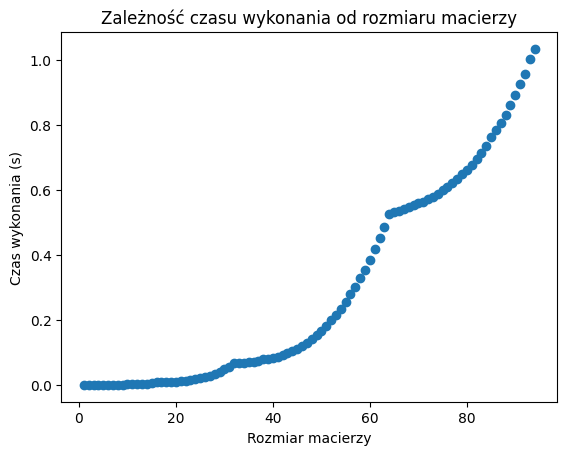

In [23]:
import matplotlib.pyplot as plt

plt.scatter(range(1, len(successful_wrappers) + 1), [wrapper.time_used for wrapper in successful_wrappers if wrapper.time_used != 0])
plt.title("Zależność czasu wykonania od rozmiaru macierzy")
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas wykonania (s)")
plt.show()

Na powyższym wykresie widać pewnego rodzaju "spowolnienie" wzrostu czasu wykonania dla niektórych rozmiarów macierzy. Spowodowane jest to faktem, że algorytm radzi sobie najlepiej z macierzami o wymiarach $2^n$ x $2^n$, ponieważ wtedy podziały na bloki można wykonywać do momentu, aż osiągną one rozmiar 1 × 1. W pozostałych przypadkach, gdy macierz ma rozmiar niebędący potęgą dwójki, podziały na bloki są nierówne, co skutktuje koniecznością pomnożenia przez sibie macierzy o wymiarach $1$ x $k$ lub $k$ x $1$.

#### Liczba operacji zmiennoprzecinkowych

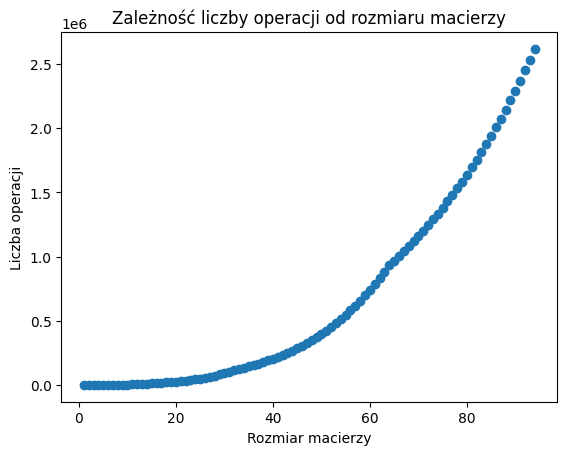

In [24]:
plt.scatter(range(1, len(successful_wrappers) + 1), [wrapper.flops for wrapper in successful_wrappers if wrapper.time_used != 0])
plt.title("Zależność liczby operacji od rozmiaru macierzy")
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Liczba operacji")
plt.show()

#### Zużycie pamięci

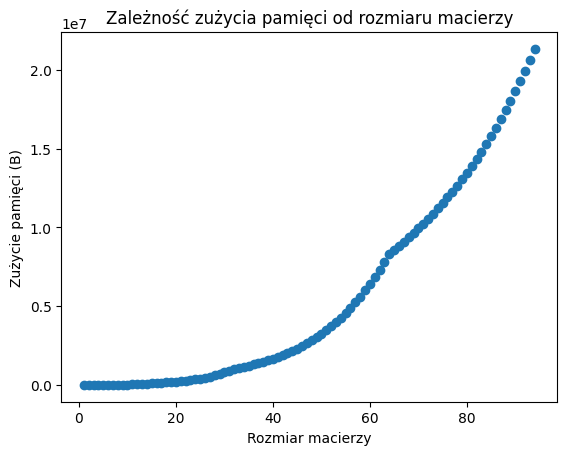

In [25]:
plt.scatter(range(1, len(successful_wrappers) + 1), [wrapper.memory_used for wrapper in successful_wrappers if wrapper.time_used != 0])
plt.title("Zależność zużycia pamięci od rozmiaru macierzy")
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Zużycie pamięci (B)")
plt.show()